In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.integrate import solve_ivp


## Refueling

In [4]:
# Constants and initial values
a_r = 0  # No radial acceleration
a_th = 185e-9  # Constant tangential acceleration (km/s^2)
t_m = 3100 * 3600  # Firing time [s]
muE = 398600  # Standard gravitational parameter of the Earth (km^3/s^2)
mu = muE  # Assign to a global variable
re = 6378  # Radius of the Earth
rGEO = 35786  # Radius of Geostationary Orbit
r0 = re + rGEO  # Initial radius of spacecraft
rdot0 = 0  # Change in radius (0 for circular orbit)
theta0 = 0  # Initial angle
thetadot0 = np.sqrt(mu / r0) / r0  # Velocity converted to rad/s

# Pack initial state vector
vec0 = [r0, rdot0, theta0, thetadot0]

# Define the ODE function
def odefun(t, vec, a_r, a_th):
    r, rdot, th, thdot = vec
    dr_dt = rdot
    drdot_dt = a_r + r * thdot**2 - mu / r**2
    dth_dt = thdot
    dthdot_dt = (a_th - 2 * rdot * thdot) / r
    return [dr_dt, drdot_dt, dth_dt, dthdot_dt]

# Time span for integration
delta_t = 100  # Time step [s]
tspan = (0, t_m)  # Integration time span
t_eval = np.arange(0, t_m + delta_t, delta_t)  # Time points for evaluation

# Solve the ODE
sol = solve_ivp(lambda t, vec: odefun(t, vec, a_r, a_th), tspan, vec0, t_eval=t_eval)

# Retrieve data from the solution
r = sol.y[0]
rdot = sol.y[1]
th = sol.y[2]
thdot = sol.y[3]

# Convert to Cartesian coordinates for plotting
x = r * np.cos(th)
y = r * np.sin(th)

# Delta V at each time step
del_v = a_th * t_eval

# Refueling stations
n_refuel = 9  # Number of refueling stations
refuel_indices = (np.arange(1, n_refuel + 1) * (len(t_eval) // (n_refuel + 1))).astype(int)
r_refuel = r[refuel_indices]
th_refuel = th[refuel_indices]
x_refuel = r_refuel * np.cos(th_refuel)
y_refuel = r_refuel * np.sin(th_refuel)



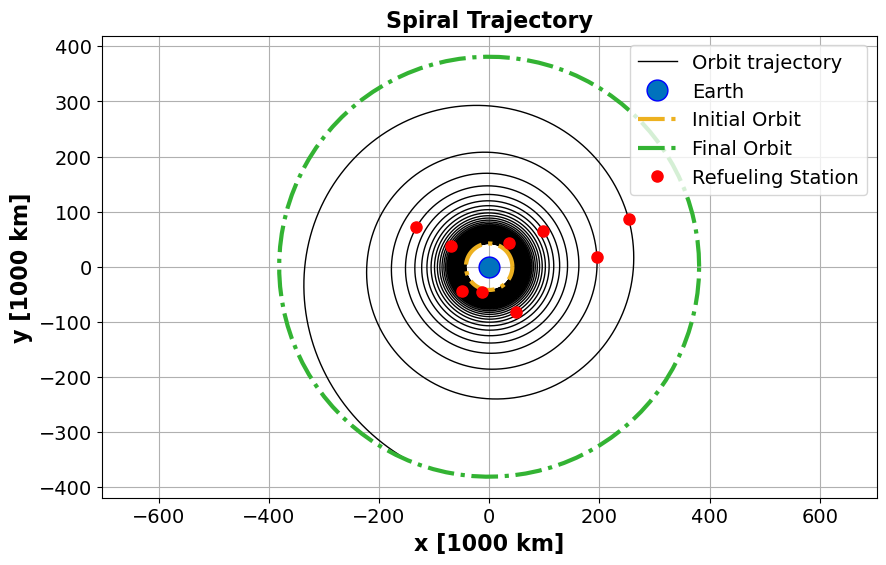

In [5]:
# Plot the spiral trajectory
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.plot(x / 1000, y / 1000, 'k', linewidth=1)  # Convert x and y to 1000 km
plt.grid(True)
plt.title('Spiral Trajectory', fontweight='bold', fontsize=16)
rmax = np.max(r) / 1000  # Convert rmax to 1000 km
plt.axis([-1.1 * rmax, 1.1 * rmax, -1.1 * rmax, 1.1 * rmax])
ax.set_aspect('equal', adjustable='datalim')  # Fix aspect ratio without forcing a square shape
plt.xlabel('x [1000 km]', fontweight='bold', fontsize=16)  # Update x-axis label
plt.ylabel('y [1000 km]', fontweight='bold', fontsize=16)  # Update y-axis label

# Plot the Earth (not to scale)
th360 = np.linspace(0, 2 * np.pi, 100)
plt.plot(0, 0, 'o', markerfacecolor=[0, 0.4470, 0.7410], markeredgecolor='b', markersize=15)

# Plot the initial and final orbits
plt.plot((r[0] * np.cos(th360)) / 1000, (r[0] * np.sin(th360)) / 1000, '-.', color=[0.9290, 0.6940, 0.1250], linewidth=3)  # Convert to 1000 km
plt.plot((r[-1] * np.cos(th360)) / 1000, (r[-1] * np.sin(th360)) / 1000, '-.', color=[0.2, 0.7, 0.2], linewidth=3)  # Convert to 1000 km

# Plot the refueling stations
plt.plot(x_refuel / 1000, y_refuel / 1000, 'or', markerfacecolor='r', markersize=8, linewidth=1)  # Convert to 1000 km

# Add legend
plt.legend(["Orbit trajectory", "Earth", "Initial Orbit", "Final Orbit", "Refueling Station"], fontsize=14)

# Increase font size for x and y ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Save the figure
plt.savefig('figures/refueling_locations.pdf')
plt.show()

## Hohmann then spiral maneurvers

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def hohmann_transfer(r1, r2, num_points=100):
    """
    Compute the coordinates of a Hohmann transfer orbit from r1 to r2.
    
    Parameters:
        r1 (float): Initial circular orbit radius (km or any unit of length)
        r2 (float): Final circular orbit radius (same unit as r1)
        num_points (int): Number of points to plot the transfer orbit
    
    Returns:
        theta_values (numpy array): True anomaly values (radians)
        r_values (numpy array): Corresponding radial distances (same unit as r1)
    """
    # Semi-major axis of the transfer ellipse
    a_transfer = (r1 + r2) / 2
    
    # Eccentricity of the transfer orbit
    e_transfer = (r2 - r1) / (r2 + r1)
    
    # True anomaly range for half the transfer (0 to pi)
    theta_values = np.linspace(0, np.pi, num_points)
    
    # Compute radial distance for each true anomaly using orbit equation
    r_values = a_transfer * (1 - e_transfer**2) / (1 + e_transfer * np.cos(theta_values))
    
    return theta_values, r_values

def plot_hohmann_transfer(r1, r2):
    """Plot the initial orbit, final orbit, and the Hohmann transfer trajectory."""
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-r2 * 1.2, r2 * 1.2)
    ax.set_ylim(-r2 * 1.2, r2 * 1.2)
    ax.set_aspect('equal')
    
    # Plot initial and final circular orbits
    circle1 = plt.Circle((0, 0), r1, color='blue', fill=False, linestyle='dashed', label='Initial Orbit')
    circle2 = plt.Circle((0, 0), r2, color='green', fill=False, linestyle='dashed', label='Final Orbit')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    
    # Get transfer trajectory
    theta_values, r_values = hohmann_transfer(r1, r2)
    
    # Convert polar to Cartesian coordinates
    x_transfer = r_values * np.cos(theta_values)
    y_transfer = r_values * np.sin(theta_values)
    
    # Plot transfer trajectory
    ax.plot(x_transfer, y_transfer, color='red', linewidth=2, label='Hohmann Transfer')
    
    # Plot central body
    ax.scatter(0, 0, color='black', s=100, label='Central Body')
    
    plt.legend()
    plt.title('Hohmann Transfer from r1={} to r2={}'.format(r1, r2))
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()



In [7]:
# Hohmann Transfer Calculations
def hohmann_delvs(r1, r2, mu):
    # Velocities in circular orbits
    v1 = np.sqrt(mu / r1)  # Initial circular orbit velocity
    v2 = np.sqrt(mu / r2)  # Final circular orbit velocity

    # Semi-major axis of the transfer ellipse
    a_transfer = (r1 + r2) / 2

    # Velocities at periapsis and apoapsis of the transfer ellipse
    v_peri = np.sqrt(2 * mu / r1 - mu / a_transfer)
    v_apo = np.sqrt(2 * mu / r2 - mu / a_transfer)

    # Delta-v for the two burns
    delta_v1 = v_peri - v1
    delta_v2 = v2 - v_apo

    return delta_v1, delta_v2

In [8]:
# Constants and initial values
a_r = 0  # No radial acceleration
a_th = 185e-9  # Constant tangential acceleration (km/s^2)
t_m = 1432 * 3600  # Firing time [s]
muE = 398600  # Standard gravitational parameter of the Earth (km^3/s^2)
mu = muE  # Assign to a global variable
re = 6378  # Radius of the Earth
rGEO = 35786  # Radius of Geostationary Orbit
r_switch=100000 # Radius of mode switching Orbit
r0 = re +r_switch  # Initial radius of spacecraft
rdot0 = 0  # Change in radius (0 for circular orbit)
theta0 = 0  # Initial angle
thetadot0 = np.sqrt(mu / r0) / r0  # Velocity converted to rad/s

# Pack initial state vector
vec0 = [r0, rdot0, theta0, thetadot0]

# Define the ODE function
def odefun(t, vec, a_r, a_th):
    r, rdot, th, thdot = vec
    dr_dt = rdot
    drdot_dt = a_r + r * thdot**2 - mu / r**2
    dth_dt = thdot
    dthdot_dt = (a_th - 2 * rdot * thdot) / r
    return [dr_dt, drdot_dt, dth_dt, dthdot_dt]

# Time span for integration
delta_t = 100  # Time step [s]
tspan = (0, t_m)  # Integration time span
t_eval = np.arange(0, t_m + delta_t, delta_t)  # Time points for evaluation

# Solve the ODE
sol = solve_ivp(lambda t, vec: odefun(t, vec, a_r, a_th), tspan, vec0, t_eval=t_eval)

# Retrieve data from the solution
r = sol.y[0]
rdot = sol.y[1]
th = sol.y[2]
thdot = sol.y[3]

# Convert to Cartesian coordinates for plotting
x = r * np.cos(th)
y = r * np.sin(th)

# Delta V at each time step
del_v = a_th * t_eval

# Refueling stations
n_refuel = 9  # Number of refueling stations
refuel_indices = (np.arange(1, n_refuel + 1) * (len(t_eval) // (n_refuel + 1))).astype(int)
r_refuel = r[refuel_indices]
th_refuel = th[refuel_indices]
x_refuel = r_refuel * np.cos(th_refuel)
y_refuel = r_refuel * np.sin(th_refuel)




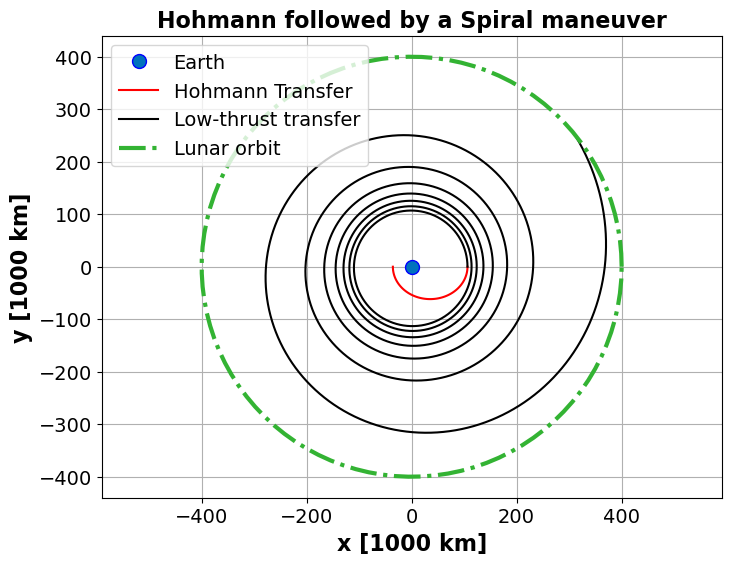

In [9]:
# Plot the spiral trajectory
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot the Earth (not to scale)
th360 = np.linspace(0, 2 * np.pi, 100)
plt.plot(0, 0, 'o', markerfacecolor=[0, 0.4470, 0.7410], markeredgecolor='b', markersize=10,label=r"Earth")


# Generate points for the Hohmann transfer ellipse
theta_values, r_values = hohmann_transfer(rGEO, r0)
# Convert polar to Cartesian coordinates
x_transfer = r_values * np.cos(theta_values)
y_transfer = r_values * np.sin(theta_values)
# Plot transfer trajectory
ax.plot(-x_transfer/1000, -y_transfer/1000, color='red', linewidth=1.5, label='Hohmann Transfer')



# Generate points for the low-thrust transfer
plt.plot(x / 1000, y / 1000, 'k', linewidth=1.5,label=r"Low-thrust transfer")  # Convert x and y to 1000 km


# Plot the initial and final orbits
#plt.plot((r[0] * np.cos(th360)) / 1000, (r[0] * np.sin(th360)) / 1000, '-.', color=[0.9290, 0.6940, 0.1250], linewidth=1)  # Convert to 1000 km
plt.plot((r[-1] * np.cos(th360)) / 1000, (r[-1] * np.sin(th360)) / 1000, '-.', color=[0.2, 0.7, 0.2], linewidth=3,label=r"Lunar orbit")  # Convert to 1000 km

# Plot the refueling stations
#plt.plot(x_refuel / 1000, y_refuel / 1000, 'or', markerfacecolor='r', markersize=8, linewidth=1)  # Convert to 1000 km



plt.grid(True)
plt.title('Hohmann followed by a Spiral maneuver', fontweight='bold', fontsize=16)
rmax = np.max(r) / 1000  # Convert rmax to 1000 km
plt.axis([-1.1 * rmax, 1.1 * rmax, -1.1 * rmax, 1.1 * rmax])
ax.set_aspect('equal', adjustable='datalim')  # Fix aspect ratio without forcing a square shape
plt.xlabel('x [1000 km]', fontweight='bold', fontsize=16)  # Update x-axis label
plt.ylabel('y [1000 km]', fontweight='bold', fontsize=16)  # Update y-axis label
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/hohmann_spiral.png')
plt.show()

### Spiral then Hohmann maneuver

In [10]:
# Constants and initial values
a_r = 0  # No radial acceleration
a_th = 185e-9  # Constant tangential acceleration (km/s^2)
t_m = 1450 * 3600  # Firing time [s]
muE = 398600  # Standard gravitational parameter of the Earth (km^3/s^2)
mu = muE  # Assign to a global variable
re = 6378  # Radius of the Earth
rGEO = 35786  # Radius of Geostationary Orbit
r_switch=100000 # Radius of mode switching Orbit
r0 = re +rGEO  # Initial radius of spacecraft
rdot0 = 0  # Change in radius (0 for circular orbit)
theta0 = 0  # Initial angle
thetadot0 = np.sqrt(mu / r0) / r0  # Velocity converted to rad/s

# Pack initial state vector
vec0 = [r0, rdot0, theta0, thetadot0]

# Define the ODE function
def odefun(t, vec, a_r, a_th):
    r, rdot, th, thdot = vec
    dr_dt = rdot
    drdot_dt = a_r + r * thdot**2 - mu / r**2
    dth_dt = thdot
    dthdot_dt = (a_th - 2 * rdot * thdot) / r
    return [dr_dt, drdot_dt, dth_dt, dthdot_dt]

# Time span for integration
delta_t = 100  # Time step [s]
tspan = (0, t_m)  # Integration time span
t_eval = np.arange(0, t_m + delta_t, delta_t)  # Time points for evaluation

# Solve the ODE
sol = solve_ivp(lambda t, vec: odefun(t, vec, a_r, a_th), tspan, vec0, t_eval=t_eval)

# Retrieve data from the solution
r = sol.y[0]
rdot = sol.y[1]
th = sol.y[2]
thdot = sol.y[3]

# Convert to Cartesian coordinates for plotting
x = r * np.cos(th)
y = r * np.sin(th)

# Delta V at each time step
del_v = a_th * t_eval


In [11]:
print(r[0])
print(r[-1])


42164.0
89684.96230803609


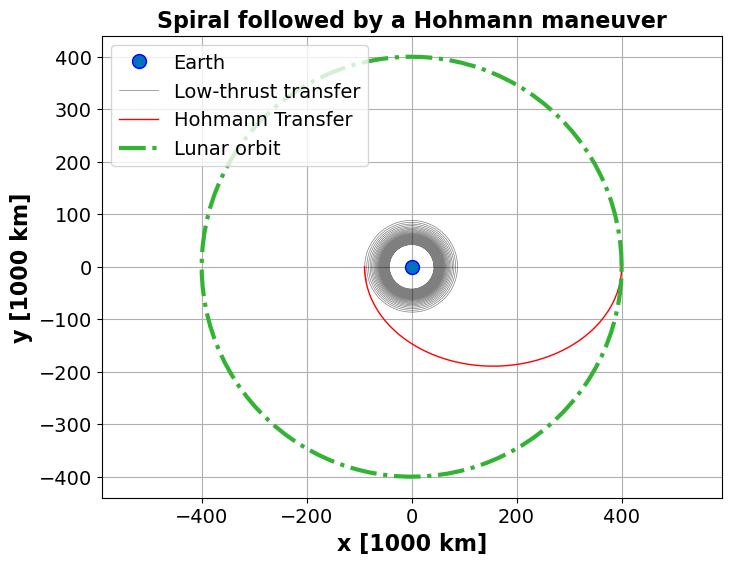

In [12]:
# Plot the spiral trajectory
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot the Earth (not to scale)
th360 = np.linspace(0, 2 * np.pi, 100)
plt.plot(0, 0, 'o', markerfacecolor=[0, 0.4470, 0.7410], markeredgecolor='b', markersize=10,label=r"Earth")

# Plot the initial and final orbits
#plt.plot((r[0] * np.cos(th360)) / 1000, (r[0] * np.sin(th360)) / 1000, '-.', color=[0.9290, 0.6940, 0.1250], linewidth=1)  # Convert to 1000 km



# Generate points for the low-thrust transfer
plt.plot(x / 1000, y / 1000, 'k', linewidth=.5,alpha=0.5, label=r"Low-thrust transfer")  # Convert x and y to 1000 km




# Generate points for the Hohmann transfer ellipse
rf=400000
theta_values, r_values = hohmann_transfer(r[-1], rf)
# Convert polar to Cartesian coordinates
x_transfer = r_values * np.cos(theta_values)
y_transfer = r_values * np.sin(theta_values)
# Plot transfer trajectory
plt.plot(-x_transfer/1000, -y_transfer/1000, color='red', linewidth=1, label='Hohmann Transfer')

plt.plot((rf * np.cos(th360)) / 1000, (rf * np.sin(th360)) / 1000, '-.', color=[0.2, 0.7, 0.2], linewidth=3,label=r"Lunar orbit")  # Convert to 1000 km








plt.grid(True)
plt.title('Spiral followed by a Hohmann maneuver', fontweight='bold', fontsize=16)
rmax = rf / 1000  # Convert rmax to 1000 km
plt.axis([-1.1 * rmax, 1.1 * rmax, -1.1 * rmax, 1.1 * rmax])
ax.set_aspect('equal', adjustable='datalim')  # Fix aspect ratio without forcing a square shape
plt.xlabel('x [1000 km]', fontweight='bold', fontsize=16)  # Update x-axis label
plt.ylabel('y [1000 km]', fontweight='bold', fontsize=16)  # Update y-axis label
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/spiral_hohmann.png')
plt.show()

___

## Spiral Only

In [67]:
# Constants and initial values
a_r = 0  # No radial acceleration
a_th = 270e-9  # Constant tangential acceleration (km/s^2)
t_m = 1800 * 3600  # Firing time [s]
muE = 398600  # Standard gravitational parameter of the Earth (km^3/s^2)
mu = muE  # Assign to a global variable
re = 6378  # Radius of the Earth
rGEO = 35786  # Radius of Geostationary Orbit
r_switch=100000 # Radius of mode switching Orbit
r0 = re +rGEO  # Initial radius of spacecraft
rdot0 = 0  # Change in radius (0 for circular orbit)
theta0 = 0  # Initial angle
thetadot0 = np.sqrt(mu / r0) / r0  # Velocity converted to rad/s

# Pack initial state vector
vec0 = [r0, rdot0, theta0, thetadot0]

# Define the ODE function
def odefun(t, vec, a_r, a_th):
    r, rdot, th, thdot = vec
    dr_dt = rdot
    drdot_dt = a_r + r * thdot**2 - mu / r**2
    dth_dt = thdot
    dthdot_dt = (a_th - 2 * rdot * thdot) / r
    return [dr_dt, drdot_dt, dth_dt, dthdot_dt]

# Time span for integration
delta_t = 100  # Time step [s]
tspan = (0, t_m)  # Integration time span
t_eval = np.arange(0, t_m + delta_t, delta_t)  # Time points for evaluation

# Solve the ODE
sol = solve_ivp(lambda t, vec: odefun(t, vec, a_r, a_th), tspan, vec0, t_eval=t_eval)

# Retrieve data from the solution
r = sol.y[0]
rdot = sol.y[1]
th = sol.y[2]
thdot = sol.y[3]

# Convert to Cartesian coordinates for plotting
x = r * np.cos(th)
y = r * np.sin(th)

# Delta V at each time step
del_v = a_th * t_eval


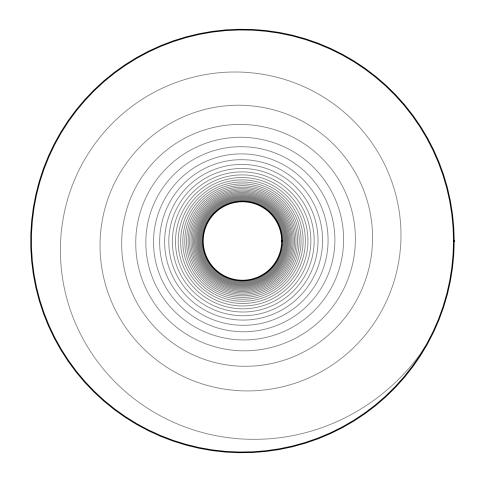

In [77]:
# Plot the spiral trajectory
plt.figure(figsize=(6, 6))
ax = plt.gca()
# Plot the Earth (not to scale)
th360 = np.linspace(0, 2 * np.pi, 100)
#plt.plot(0, 0, 'o', markerfacecolor=[0, 0.4470, 0.7410], markeredgecolor='b', markersize=10,label=r"Earth")
# Plot the initial and final orbits
plt.plot((r[0] * np.cos(th360)) / 1000, (r[0] * np.sin(th360)) / 1000, '-', color=[0, 0, 0], linewidth=1)  # Convert to 1000 km
# Generate points for the low-thrust transfer
plt.plot(x / 1000, y / 1000, 'k', linewidth=.6,alpha=0.5, label=r"Low-thrust transfer")  # Convert x and y to 1000 km

# Generate points for the Hohmann transfer ellipse
rf=np.sqrt(x[-1]**2+y[-1]**2)
theta_values, r_values = hohmann_transfer(r[-1], rf)
# Convert polar to Cartesian coordinates
x_transfer = r_values * np.cos(theta_values)
y_transfer = r_values * np.sin(theta_values)
# Plot transfer trajectory
#plt.plot(-x_transfer/1000, -y_transfer/1000, color='red', linewidth=1, label='Hohmann Transfer')

plt.plot((rf * np.cos(th360)) / 1000, (rf * np.sin(th360)) / 1000, '-', color=[0, 0, 0], linewidth=1,label=r"Lunar orbit")  # Convert to 1000 km

rmax = rf / 1000  # Convert rmax to 1000 km

ax.set_aspect('equal', adjustable='datalim')  # Fix aspect ratio without forcing a square shape
ax.axis('off')
plt.savefig('figures/empty_spiral.png', bbox_inches='tight', pad_inches=0)

plt.show()